# Dominant Sequences
First use MeanShift to cluster the strain population using the precomputed Levenshtein distance matrix. Then find the Levenshtein centroid of each cluster.

Levenshtein Centroid: $$\widehat{x}_i^{\text{dom}} = argmin_{x\in P_i^t} \sum_{y \in P_i^t} \theta(x,y)$$
- Where $P_i^t$ is a cluster of the strain population at time $t$
- $\bigcup P_i^t = P^t$, the total population at time $t$
- $\theta(x,y)$ is the edit distance (Levenshtein) between $x$ and $y$
- Compute dominant strains for north starting at 2003-2004 and south starting at 2004

### Running Processes

Computations are done in:
- `compute_domseq.py`
- `run_compute_domseq.sh`

To run, navigate to terminal and do

`chmod ugo+rwx run_compute_domseq.sh`

`./run_compute_domseq.sh`

## Example Computation
- Compute dominant sequences for North H1N1 HA 2008-09 season

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')
from domseq import DomSeq, save_model, load_model
from Levenshtein import distance
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.manifold import MDS

In [2]:
# HEMISPHERE: 'north', 'south'
# SUBTYPE: 'h1n1', 'h3n2'
# SEGMENT: 'ha', 'na'
# N: 0-19
HEMISPHERE, SUBTYPE, SEGMENT, N = 'north', 'h1n1', 'ha', '5'
n = int(N)

# construct seasons
YEARS = []
if HEMISPHERE == 'north':
    for i in np.arange(3, 23):
        YEAR = ''
        if i < 10:
            YEAR += '0' + str(i)
        else:
            YEAR += (str(i))
        if i + 1 < 10:
            YEAR += '_0' + str(i + 1)
        else:
            YEAR += '_' + str(i + 1)
        YEARS.append(YEAR)
else:
    for i in np.arange(3, 23):
        if i < 10:
            YEARS.append('0' + str(i))
        else:
            YEARS.append(str(i))
            
# directory paths
OUT_DIR = HEMISPHERE + '_' + SUBTYPE
NAME = OUT_DIR + '_' + YEARS[n]
NAME_SEG = OUT_DIR + '_' + SEGMENT + '_' + YEARS[n]
# save data
SAVE_DATA_DIR = 'results/' + OUT_DIR + '_' + SEGMENT + '/' + NAME_SEG + '/'
os.makedirs(SAVE_DATA_DIR, exist_ok=True)
# data
DATA_DIR = '../raw_data/merged/' + OUT_DIR + '/' + NAME + '.csv'

# length to truncate sequences
TRUNC = 565
if SEGMENT == 'na':
    TRUNC = 468

In [3]:
# initialize the DomSeq
domseq = DomSeq(seq_trunc_length=TRUNC, random_state=42)
# load data
seq_df = pd.read_csv(DATA_DIR)
if SEGMENT == 'na':
    seq_df = seq_df.drop(columns=['acc','sequence'])
    seq_df.rename(columns={'acc_na':'acc','sequence_na':'sequence'}, inplace=True)

In [4]:
def _dm_to_df(dm):
    columns = np.arange(0, dm.shape[1])
    index = np.arange(0, dm.shape[0])
    df = pd.DataFrame(dm, columns=columns, index=index)
    return df
    
def _compute_domseq_distance_matrix(seq_df):
    seqs = seq_df['sequence'].values
    n = len(seqs)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i, j] = distance(seqs[i][:TRUNC], seqs[j][:TRUNC])
    dist_matrix += dist_matrix.T
    dm = _dm_to_df(dist_matrix)
    return dm

dm = _compute_domseq_distance_matrix(seq_df)

In [5]:
# clustering
embedding = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
dm_embed = embedding.fit_transform(dm)
bandwidth = estimate_bandwidth(dm_embed, quantile=0.3, random_state=42)
clustering = MeanShift(bandwidth=bandwidth)
clustering_predictions = clustering.fit_predict(dm_embed)
unique_clusters = np.unique(clustering_predictions)

In [7]:
# dominant sequences
dom_seqs = pd.DataFrame(columns=seq_df.columns)
cluster_sizes = []
for class_ in unique_clusters:
    wanted_names = dm.columns[clustering_predictions == class_]
    # find the centroid in this cluster
    cluster_seq_df = seq_df.iloc[wanted_names]
    cluster_dm = dm.iloc[wanted_names, wanted_names]
    argmin = np.argmin(cluster_dm.sum(axis='columns').values)
    # save sequence
    dom_seqs = dom_seqs.append(cluster_seq_df.iloc[argmin])
    cluster_sizes.append(len(wanted_names))
dom_seqs['cluster_size'] = cluster_sizes
dom_seqs

,acc,name,date,sequence,acc_na,sequence_na,cluster_size
49,EPI525366,A/New_York/1126/2008,2008-03-06,MKVKLLVLLCTFTATYADTICIGYHANNSTDTVDTVLEKNVTVTHS...,EPI525368,MNPNQKIITIGSISIAIGIISLMLQIGNIISIWASHSIQTGSQNNT...,579
191,EPI168217,A/Hong_Kong/1794/2008,2008-07-23,MKVKLLVLLCTFTATYADTICIGYHANNSTDTVDTVLEKNVTVTHS...,EPI172639,MNPNQKIITIGSISIAIGIISLMLQIGNIISIWASRSIQTGSQNHT...,79
616,EPI326504,A/Hong_Kong/H090-665-V1,2009-02-07,MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,EPI326623,MNPNQKIITIGSVCMTIGMANLILQIGNIISIWISHSIQLVNQNQI...,1
657,EPI482799,A/Iowa/02/2009,2009-02-13,MKAILVVLLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,EPI482798,MNTNQRIITIGTVCMIVGIISLLLQIGNIVSLWISHSIQTGWENHT...,1
615,EPI326503,A/Hong_Kong/H090-667-V1,2009-02-07,MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,EPI326622,MNPNQKIITIGSVCMTIGMANLILQIGNIISIWISHSIQLGNQNQI...,1
614,EPI326502,A/Hong_Kong/H090-667-V2,2009-02-07,MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,EPI326621,MNPNQKIITIGSVCMTIGMANLILQIGNIISIWISHSIQLGNQNQI...,1
620,EPI326467,A/Hong_Kong/H090-751-V3,2009-02-08,MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,EPI326586,MNPNQKIITIGSVCMTIGMANLILQIGNIISIWISHSIQLGNQNQI...,1
644,EPI210234,A/Townsville/2/2009,2009-02-11,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,EPI211637,MNPNQKIITIGSVSLTISTICFFMQIAILITTVTLHFKQYEFNSPP...,1


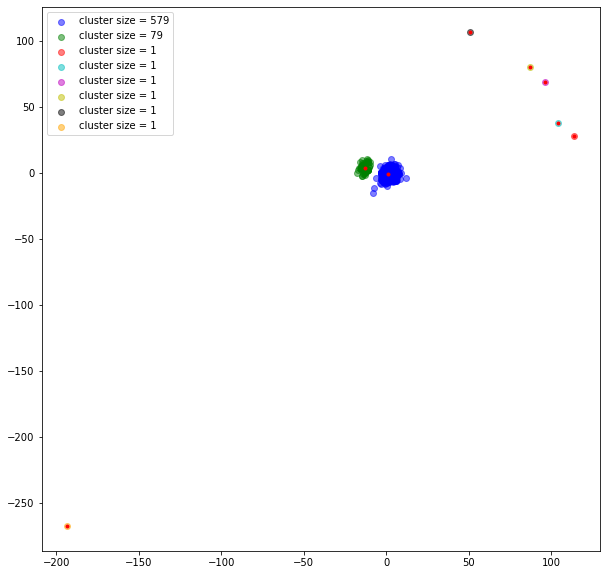

In [8]:
pts = []
for _class in unique_clusters:
    cluster_idx = np.where(clustering_predictions == _class)[0]
    dm_embed_class = dm_embed[cluster_idx]
    pts.append(dm_embed_class)

colors = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500', '#800080', '#008080'])
plt.figure(figsize=(10,10))
for pt in pts:
    plt.scatter(pt[:,0], pt[:,1], alpha=0.5, c=next(colors), marker='o', label = 'cluster size = {}'.format(len(pt)))
# Levenshtein centroids
centroids = dm_embed[dom_seqs.index]
plt.scatter(centroids[:,0], centroids[:,1], c='r', marker='.');
# plt.xlim(-50, 50)
# plt.ylim(-50, 50)
plt.legend();

In [4]:
# the above code is in the domseq module
dom_seqs = domseq.compute_domseq(seq_df, save_data=SAVE_DATA_DIR)
# dom_seqs.to_csv(SAVE_DATA_DIR + 'dom_seqs.csv', index=False)